# MITGCM Event Composition Analysis: Diagnosing Advection effects

**Background**: Advection can artificially reduce Eulerian decorrelation length scales by causing coherent ocean features to move past fixed observation locations, leading to apparent spatial and temporal decorrelation that does not reflect the true evolution of the feature. 

Plotting a Hovmöller diagram at fixed cross-shore distance $n$ (for alongshore decorrelation scale $L_s$​) or at fixed alongshore position $s$ (for cross-shore decorrelation scale $L_n$) allows you to visualize the propagation of features over time. If the features exhibit clear diagonal patterns—indicative of advection—then comparing these plots with the decorrelation length scale time series can help diagnose whether variations in $L_s(n,t)$ or $L_n(s,t)$ are being driven by the movement of features rather than their intrinsic spatial structure.

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook

In [1]:
%matplotlib inline

Import python libraries

In [2]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from netCDF4 import Dataset, num2date
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import cmocean
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator

# Set path to access python functions
ROOT = '/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/'
sys.path.append(ROOT + 'AirSeaCoupling/tools/')

#--- Other Functions ---# 
import cartopy_figs as cart
from autocorr import compute_autocorr, compute_decor_scale
from spectra import spectrum1D_frequency
from lsf import unweighted_lsf, compute_amp_phase, compute_amp_phase_unc, detrend
from structure_functions import compute_structure_function
import stats

Set data analysis parameters

In [3]:
# Set processing parameters
option_plot          = 0      # Specifies if supplementary plots are plotted
option_var           = 'temp' # Specifies which variable will analyzed. Options include: temp, sal, density
option_depth         = 0.5   # Specifies the depth level in meter at which the decorrelation data is computed

# Set time and space parameters
L            = 1.5                           # Specifies the distance between points (assumes that ds = dn)
estimator    = 'biased'                      # Specifies the approach for estimating the autocorrelation function    
lat_bnds     = [33, 35]                      # Specifies the latitude bounds for the region to analyze
lon_bnds     = [-123 % 360, -120 % 360]      # Specifies the longitude bounds for the region to analyze
start_time = datetime(2016, 10, 1, 0, 0, 0)  # Specifies the start time of the event period
end_time = datetime(2016, 11, 1, 0, 0, 0)    # Specifies the end time of the event period
event_time_bnds = [start_time, end_time]     # Specifies the event period

# Set path to project directory
PATH = ROOT + 'AirSeaCoupling/data/mitgcm/SWOT_MARA_RUN4_LY/'
PATH_figs =  ROOT + 'AirSeaCoupling/figs_server/mitgcm/scale_analysis/'
PATH_bathy  = ROOT + 'AirSeaCoupling/data/bathymetry/'

# Set plotting parameters 
fontsize = 14

Load intermediate mitgcm data (coordinate transformed)

In [ ]:
#--- MITgcm data mapped into (s,n)-space ---# 
if option_var == 'temp':
    filename = PATH + "mitgcm_coord_transform_sn_temp_isobath_2000_res_" + str(L) + "_depth_" + str(option_depth) + "m.npz"
elif option_var == 'sal':
    filename = PATH + "mitgcm_coord_transform_sn_sal_isobath_2000_res_" + str(L) + "_depth_" + str(option_depth) + "m.npz"
elif option_var == 'density':
    filename = PATH + "mitgcm_coord_transform_sn_rho_isobath_2000_res_" + str(L) + "_depth_" + str(option_depth) + "m.npz"

# Load data 
data_struct = np.load(filename, allow_pickle=True)

# Extract data variables
s_coord    = data_struct["s"]
n_coord    = data_struct["n"]
time       = data_struct["time"]
data       = data_struct["data"]

# Convert cftime.DatetimeGregorian to Python datetime objects
time_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time])

# Grab data from the event time period
idx_time = (time_dt >= event_time_bnds[0]) & (time_dt <= event_time_bnds[1])
time_event = time_dt[idx_time]
data_event = data[idx_time,:,:]

#--- Decorrelation Length Scale data  ---# 
if option_var == 'temp':
    filename_along = PATH + "mitgcm_along_isobath_decorr_scale_temp_depth_" + str(option_depth) + "m.npz"
    filename_cross = PATH + "mitgcm_cross_isobath_decorr_scale_temp_depth_" + str(option_depth) + "m.npz"
elif option_var == 'sal':
    filename_along = PATH + "mitgcm_along_isobath_decorr_scale_sal.npz"
    filename_cross = PATH + "mitgcm_cross_isobath_decorr_scale_sal.npz"
elif option_var == 'density':
    filename_along = PATH + "mitgcm_along_isobath_decorr_scale_rho.npz"
    filename_cross = PATH + "mitgcm_cross_isobath_decorr_scale_rho.npz"

# Load data 
data_struct_along = np.load(filename_along, allow_pickle=True)
data_struct_cross = np.load(filename_cross, allow_pickle=True)

# Extract data variables
n_scale    = data_struct_along["n"]
time_scale = data_struct_along["time"]
Ls         = data_struct_along["delta_s"]
Ls_mt      = data_struct_along["delta_s_mt"]
Ls_stdmt    = data_struct_along["delta_s_stdmt"]
Ls_mn      = data_struct_along["delta_s_mn"]
Ls_stdmn   = data_struct_along["delta_s_stdmn"]

s_scale    = data_struct_cross["n"]
time_scale = data_struct_cross["time"]
Ln         = data_struct_cross["delta_n"]
Ln_mt      = data_struct_cross["delta_n_mt"]
Ln_stdmt    = data_struct_cross["delta_n_stdmt"]
Ln_ms      = data_struct_cross["delta_n_ms"]
Ln_stdms   = data_struct_cross["delta_n_stdms"]

# Grab data from the event time period
idx_time = (time_scale >= event_time_bnds[0]) & (time_scale <= event_time_bnds[1])
time_scale_event = time_scale[idx_time]
Ls_event = Ls[idx_time,:]
Ln_event = Ln[idx_time,:]

Ls_mn_event    = Ls_mn[idx_time]
Ls_stdmn_event = Ls_stdmn[idx_time]

Ln_ms_event    = Ln_ms[idx_time]
Ln_stdms_event = Ln_stdms[idx_time]

Pick a slice along constant s and n

In [49]:
#--- Slice in s ---# 
s_o = 50

# Find slicing indicies for decorrelation scale and raw data
idx_s = np.argmin(np.abs(s_scale - s_o))

# Slice arrays
Ln_s = Ln_event[:,idx_s]
data_s = np.squeeze(data_event[:,idx_s,:])

#--- Slice in n ---# 
n_o = 30

# Find slicing indicies for decorrelation scale and raw data
idx_n = np.argmin(np.abs(n_scale - n_o))

# Slice arrays
Ls_n = Ls_event[:,idx_n]
data_n = np.squeeze(data_event[:,:,idx_n])

Plot the hovmuller diagram with the decorrelation length scale along side 

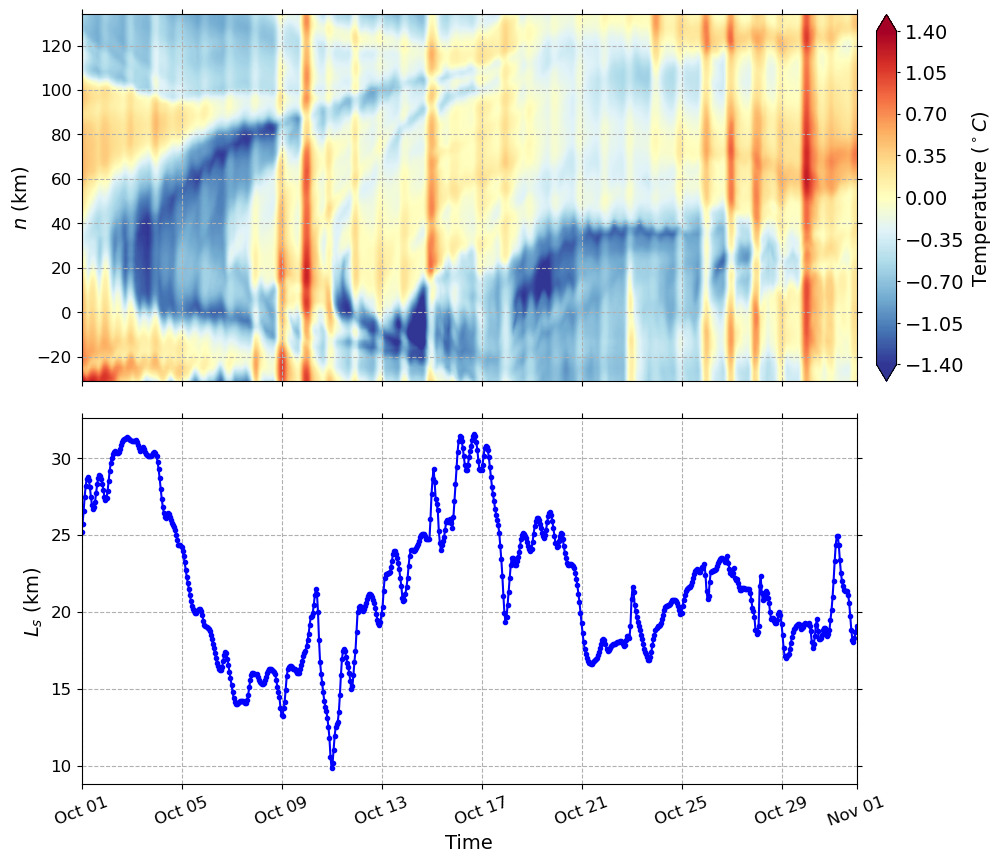

In [ ]:
# Set plotting parameters
cmap = plt.get_cmap('RdYlBu_r')  # plt.get_cmap(cmocean.cm.thermal)
levels = np.arange(-1.4, 1.4, 0.01)     # Specifies the contour levels of subplot 1
fontsize = 14  # Set your desired fontsize

# Create figure and GridSpec layout
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 1, height_ratios=[1, 1], hspace=0.1)

#--- Subplot 1 ---# 
ax1 = fig.add_subplot(gs[0])

# Plot hovmoller
mesh0 = ax1.contourf(
    time_event, n_scale, data_s.T,
    levels=levels, cmap=cmap, extend='both'
)

# Manually place colorbar next to ax1, without shrinking ax1
cbar_ax = fig.add_axes([ax1.get_position().x1 + 0.02, 
                        ax1.get_position().y0, 
                        0.02, 
                        ax1.get_position().height])
cb = fig.colorbar(mesh0, cax=cbar_ax)
cb.set_label(r"Temperature ($^\circ C$)", fontsize=fontsize)
cb.set_ticks(np.arange(-1.4,1.4+0.35,0.35))
cb.ax.tick_params(length=2.5, labelsize=fontsize)

# Set axis properties
ax1.set_ylabel(r'$n$ (km)', fontsize=fontsize)
ax1.grid(True, linestyle='--')
ax1.set_xticklabels([])
ax1.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)

#--- Subplot 2 ---#
ax2 = fig.add_subplot(gs[1])

# Plot the power spectrum
ax2.plot(time_event, Ln_s, '.-b')

# Set axis properties
ax2.set_xlabel(r'Time', fontsize=fontsize)
ax2.set_ylabel(r'$L_s$ (km)', fontsize=fontsize)
ax2.grid(True, linestyle='--')
ax2.set_xlim((np.min(time_scale_event), np.max(time_scale_event)))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(ax2.get_xticklabels(), rotation=20)
ax2.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)

plt.show()

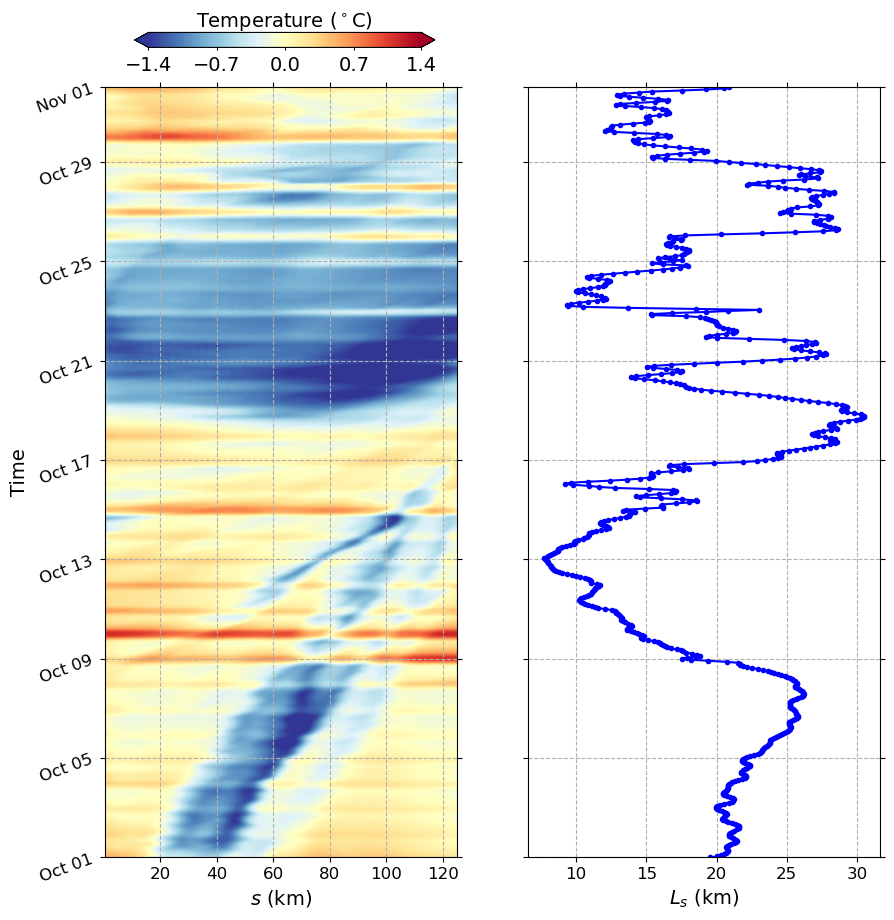

In [69]:
# Set plotting parameters
cmap = plt.get_cmap('RdYlBu_r')  # plt.get_cmap(cmocean.cm.thermal)
levels = np.arange(-1.4, 1.4, 0.01)     # Specifies the contour levels of subplot 1
fontsize = 14  # Set your desired fontsize

# Create figure and GridSpec layout
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], hspace=0.1)

#--- Subplot 1 ---# 
ax1 = fig.add_subplot(gs[0])

# Plot hovmoller
mesh0 = ax1.contourf(
    s_scale, time_event, data_n,
    levels=levels, cmap=cmap, extend='both'
)

# Manually place colorbar next to ax1, without shrinking ax1
cax1 = fig.add_axes([0.155, 0.92, 0.30, 0.015])  
cb = fig.colorbar(mesh0, cax=cax1,orientation='horizontal')
cb.set_label(r"Temperature ($^\circ$C)", fontsize=fontsize)
cb.set_ticks(np.arange(-1.4,1.4+0.7,0.7))
cb.ax.tick_params(length=2.5, labelsize=fontsize)
cb.ax.xaxis.set_label_position('top')

# Set axis properties
ax1.set_xlabel(r'$s$ (km)', fontsize=fontsize)
ax1.set_ylabel(r'Time', fontsize=fontsize)
ax1.grid(True, linestyle='--')
ax1.set_ylim((np.min(time_scale_event), np.max(time_scale_event)))
ax1.yaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(ax1.get_yticklabels(), rotation=20)
ax1.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)

#--- Subplot 2 ---#
ax2 = fig.add_subplot(gs[1])

# Plot the power spectrum
ax2.plot(Ls_n, time_event, '.-b')

# Set axis properties
ax2.set_xlabel(r'$L_s$ (km)', fontsize=fontsize)
ax2.grid(True, linestyle='--')
ax2.set_yticklabels([])
ax2.set_ylim((np.min(time_scale_event), np.max(time_scale_event)))
ax2.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)

plt.show()

In [39]:
# Set plotting parameters
cmap1 = plt.get_cmap('RdYlBu_r')         # Specifies the colormap of subplot 1
cmap2 = plt.get_cmap(cmocean.cm.deep_r)  # Specifies the colormap of subplot 2
levels1 = np.arange(-1.4, 1.4, 0.01)     # Specifies the contour levels of subplot 1
levels2 = np.arange(5, 30, 0.5)          # Specifies the contour levels of subplot 2
num_frames = len(time_event)             # Specifies the number of frames
frame_step = 1                           # Specifies the number of frames skipped

# Create figure and axes
fig, axes = plt.subplots(1,2, figsize=(14, 6))
suptitle = fig.suptitle(f"{str(time_event[0])}", fontsize=fontsize, x=0.5, y=0.99)
axes = np.atleast_1d(axes)               # Ensure it's always iterable

# Create colorbar axes 
cax1 = fig.add_axes([0.13, 0.91, 0.25, 0.03])  
cax2 = fig.add_axes([0.63, 0.91, 0.25, 0.03]) 

# --- Initialize subplots and colorbars --- #

#--- Subplot 1 ---#

# Plot Temperature field at t = t0
mesh0 = axes[0].contourf(
    s_coord, n_coord, data_event[0, :, :].T,
    levels=levels1, cmap=cmap1, extend='both'
)

# Plot the vertical line identifying the s slice
axes[0].axvline(x=s_o, color='k', linestyle='--', linewidth=2)

# Set up colorbar and its attributes
cb = fig.colorbar(mesh0, cax=cax1, orientation='horizontal')
cb.set_label(r"Temperature ($^\circ$C)", fontsize=fontsize-1)
cb.set_ticks(np.arange(-1.4,1.4+0.7,0.7))
cb.ax.tick_params(length=2.5,labelsize=fontsize-1)
cb.ax.xaxis.set_label_position('top')

# Set axis properties
axes[0].set_xlabel(r'$s$ (km)')
axes[0].set_ylabel(r'$n$ (km)')
axes[0].grid(True, linestyle='--')
axes[0].set_xlim((0,125))
axes[0].set_aspect('equal', adjustable='box')

#--- Subplot 2 ---#

# Plot the hovmoller diagram
mesh0 = axes[1].contourf(
    time_event, n_scale, data_s.T,
    levels=levels1, cmap=cmap1, extend='both'
)

# Plot the vertical line identifying the time step 
axes[1].axvline(x=time_event[0], color='k', linestyle='--', linewidth=2)

# Set up colorbar and its attributes
cb = fig.colorbar(mesh0, cax=cax2, orientation='horizontal')
cb.set_label(r"Temperature ($^\circ$C)", fontsize=fontsize-1)
cb.set_ticks(np.arange(-1.4,1.4+0.7,0.7))
cb.ax.tick_params(length=2.5,labelsize=fontsize-1)
cb.ax.xaxis.set_label_position('top')

# Set axis properties
axes[1].set_xlabel('Time')
axes[1].set_ylabel(r'$n$ (km)')
axes[1].grid(True, linestyle='--')
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(axes[1].get_xticklabels(), rotation=20)

# Set figure layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# --- Animation update function --- #
def update(frame):

    # Update progress statement
    print(f"Rendering frame {frame}", flush=True)

    # Update figure title 
    suptitle.set_text(f"{str(time_event[frame])}")

    # Clear and plot the temperature field at t = ti
    axes[0].clear()
    mesh1 = axes[0].contourf(
        s_coord, n_coord, data_event[frame, :, :].T,
        levels=levels1, cmap=cmap1, extend='both'
    )

    # Plot the vertical line identifying the s slice
    axes[0].axvline(x=s_o, color='k', linestyle='--', linewidth=2)

    # Set axis attributes
    axes[0].set_xlabel(r'$s$ (km)')
    axes[0].set_ylabel(r'$n$ (km)')
    axes[0].grid(True, linestyle='--')
    axes[0].set_xlim((0,125))
    axes[0].set_aspect('equal', adjustable='box')

    # Clear and plot the decorrelation field at t = ti
    axes[1].clear()
    mesh2 = axes[1].contourf(
        time_event, n_scale, data_s.T,
        levels=levels1, cmap=cmap1, extend='both'
    )

    # Plot the vertical line identifying the time step 
    axes[1].axvline(x=time_scale_event[frame], color='k', linestyle='--', linewidth=2)

    # Set axis properties
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel(r'$n$ (km)')
    axes[1].grid(True, linestyle='--')
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.setp(axes[1].get_xticklabels(), rotation=20)

    return []

# --- Create animation --- #
ani = FuncAnimation(
    fig, update,
    frames=range(0, num_frames, frame_step),
    blit=False
)

# --- Save animation --- #
writer = FFMpegWriter(fps=5, metadata={'artist': 'Temperature field and along decorrelation scale evolution'})
ani.save(
    PATH_figs + f'event_temp_along_hovmoller_evolution_{str(time_event[0])[:10]}.mp4',
    writer=writer
)

Rendering frame 0


/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_18496/3905031531.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


Rendering frame 0
Rendering frame 1
Rendering frame 2
Rendering frame 3
Rendering frame 4
Rendering frame 5
Rendering frame 6
Rendering frame 7
Rendering frame 8
Rendering frame 9
Rendering frame 10
Rendering frame 11
Rendering frame 12
Rendering frame 13
Rendering frame 14
Rendering frame 15
Rendering frame 16
Rendering frame 17
Rendering frame 18
Rendering frame 19
Rendering frame 20
Rendering frame 21
Rendering frame 22
Rendering frame 23
Rendering frame 24
Rendering frame 25
Rendering frame 26
Rendering frame 27
Rendering frame 28
Rendering frame 29
Rendering frame 30
Rendering frame 31
Rendering frame 32
Rendering frame 33
Rendering frame 34
Rendering frame 35
Rendering frame 36
Rendering frame 37
Rendering frame 38
Rendering frame 39
Rendering frame 40
Rendering frame 41
Rendering frame 42
Rendering frame 43
Rendering frame 44
Rendering frame 45
Rendering frame 46
Rendering frame 47
Rendering frame 48
Rendering frame 49
Rendering frame 50
Rendering frame 51
Rendering frame 52
Ren

Plot the spatial domain for the gridded data

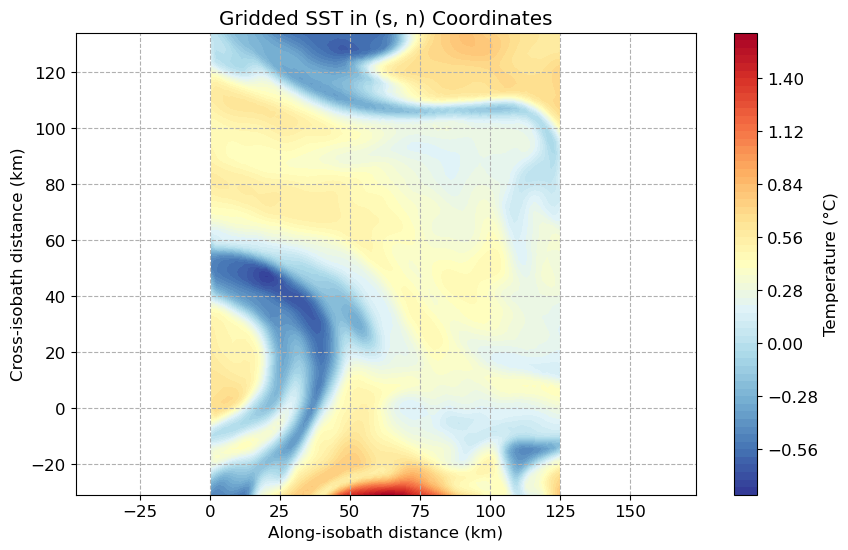

In [20]:
# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Set plotting parameters
S, N = np.meshgrid(s_coord, n_coord)

# Create figure
fig = plt.figure(figsize=(10, 6))

# Plot 
plt.contourf(s_coord, n_coord, data_event[1,:,:].T, cmap='RdYlBu_r',levels=60)

# Set figure attributes
plt.title('Gridded SST in (s, n) Coordinates')
plt.xlabel('Along-isobath distance (km)')
plt.ylabel('Cross-isobath distance (km)')
plt.colorbar(label='Temperature (°C)')
plt.grid(True,linestyle='--')
plt.axis('equal')

# Show the plot
plt.show()

# Save figure
fig.savefig(fname = PATH_figs + 'Temperature_sn_map', bbox_inches = 'tight', dpi=300)